In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

df = pd.read_csv("clean_data.csv")

df['ser_start_dt'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['ser_start'], format='%y%m%d %H:%M:%S')

df['arrival_dt'] = df['ser_start_dt'] - pd.to_timedelta(df['q_time'], unit='s')

df = df.sort_values('arrival_dt')


  > Lambda estimada: 3.7308 clientes/hora
  > Prueba Chi-Cuadrada P-Valor: 7.8880e-18


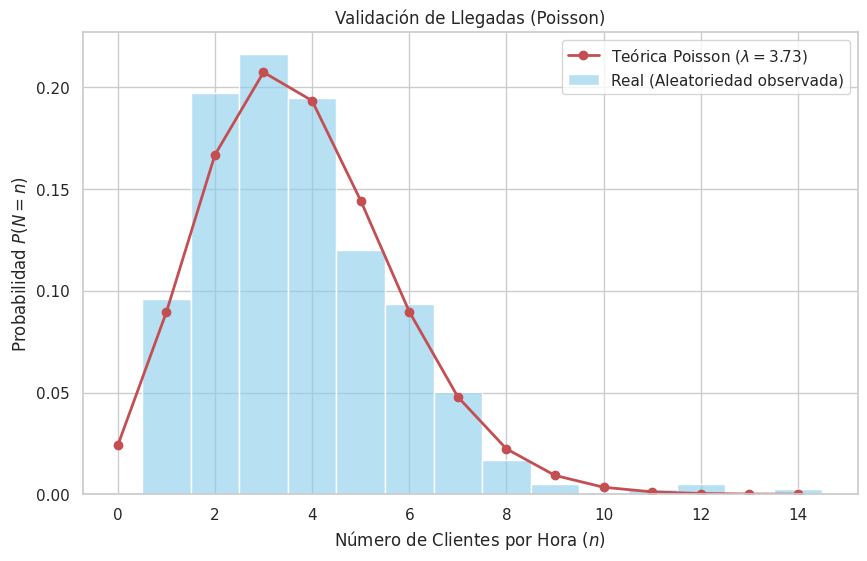

In [22]:
llegadas_por_hora = df.set_index('arrival_dt').resample('1h').size()
llegadas_por_hora = llegadas_por_hora[llegadas_por_hora > 0]

lambda_poisson = llegadas_por_hora.mean()
print(f"  > Lambda estimada: {lambda_poisson:.4f} clientes/hora")

obs_counts = llegadas_por_hora.value_counts().sort_index()
obs_counts = obs_counts.reindex(range(obs_counts.index.min(), obs_counts.index.max() + 1), fill_value=0)

f_obs = obs_counts.values
f_exp = stats.poisson.pmf(obs_counts.index, lambda_poisson) * len(llegadas_por_hora)
f_exp = f_exp * (f_obs.sum() / f_exp.sum()) # Normalizar

chi2_stat, p_val_chi2 = stats.chisquare(f_obs, f_exp)
print(f"  > Prueba Chi-Cuadrada P-Valor: {p_val_chi2:.4e}")

plt.figure()
x_k = np.arange(0, llegadas_por_hora.max() + 1)
sns.histplot(llegadas_por_hora, stat='density', discrete=True, color='skyblue', label='Real (Aleatoriedad observada)', alpha=0.6)
plt.plot(x_k, stats.poisson.pmf(x_k, lambda_poisson), 'ro-', lw=2, label=rf'Teórica Poisson ($\lambda={lambda_poisson:.2f}$)')

plt.title('Validación de Llegadas (Poisson)')
plt.xlabel('Número de Clientes por Hora ($n$)')
plt.ylabel('Probabilidad $P(N=n)$')
plt.legend()
plt.show()

Caja 1:
  > Tasa constante de servicio (mu): 0.0025 serv/seg
  > Tiempo promedio: 403.95 segundos
  > Prueba K-S P-Valor: 5.5016e-06
Caja 2:
  > Tasa constante de servicio (mu): 0.0028 serv/seg
  > Tiempo promedio: 355.32 segundos
  > Prueba K-S P-Valor: 1.3585e-02
Caja 3: Datos insuficientes.


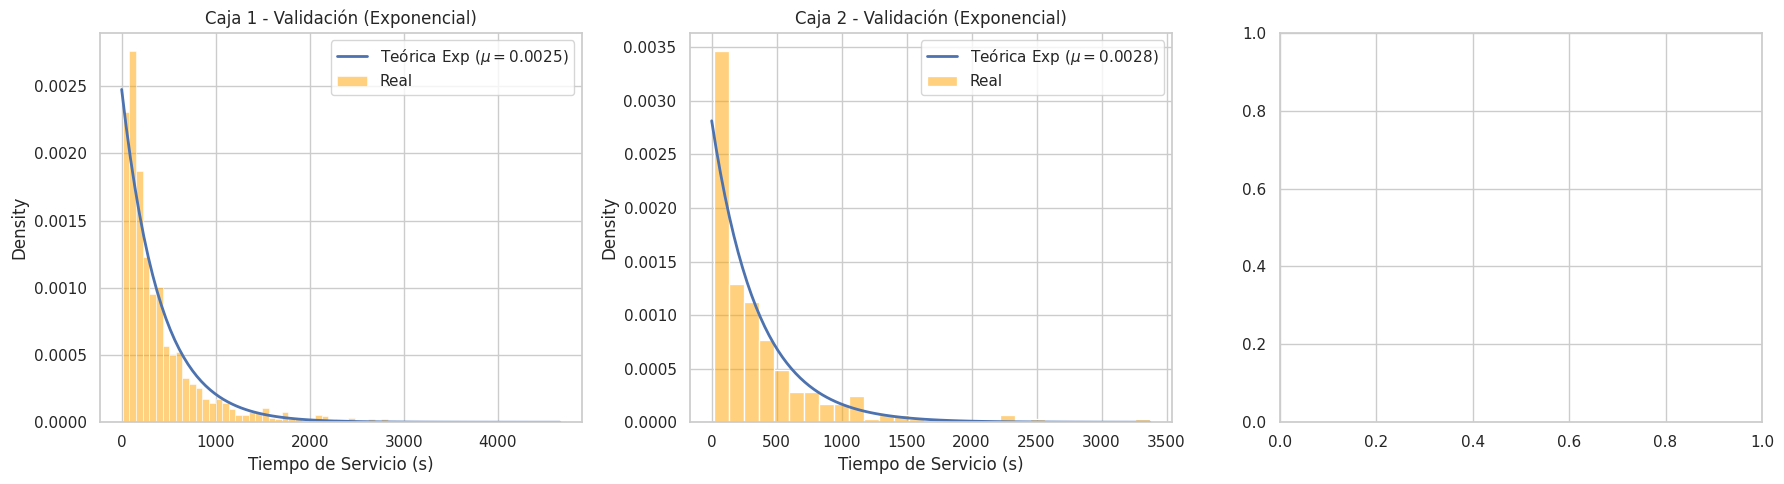

In [21]:
cajas = sorted(df['caja'].unique())

fig, axes = plt.subplots(1, len(cajas), figsize=(6 * len(cajas), 5))
if len(cajas) == 1: axes = [axes]

for i, caja in enumerate(cajas):
    datos_caja = df[df['caja'] == caja]['ser_time'].dropna()
    datos_caja = datos_caja[datos_caja > 0]

    if len(datos_caja) < 10:
        print(f"Caja {caja}: Datos insuficientes.")
        continue

    loc_s, scale_s = stats.expon.fit(datos_caja, floc=0)
    mu_caja = 1 / scale_s

    print(f"Caja {caja}:")
    print(f"  > Tasa constante de servicio (mu): {mu_caja:.4f} serv/seg")
    print(f"  > Tiempo promedio: {scale_s:.2f} segundos")

    ks_stat_box, p_val_box = stats.kstest(datos_caja, 'expon', args=(0, scale_s))
    print(f"  > Prueba K-S P-Valor: {p_val_box:.4e}")

    ax = axes[i]
    sns.histplot(datos_caja, stat='density', color='orange', alpha=0.5, label='Real', ax=ax)

    x_box = np.linspace(0, datos_caja.max(), 100)
    ax.plot(x_box, stats.expon.pdf(x_box, scale=scale_s), 'b-', lw=2, label=rf'Teórica Exp ($\mu={mu_caja:.4f}$)')

    ax.set_title(f'Caja {caja} - Validación (Exponencial)')
    ax.set_xlabel('Tiempo de Servicio (s)')
    ax.legend()

plt.tight_layout()
plt.show()